## Librairies

In [9]:
import numpy as np
import pandas as pd
import os
import itertools

## VISUALIZATION ##
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## TORCH ##
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

## KMEANS ##
from kmeans_pytorch import kmeans

## SPARSEBM ##
from sparsebm import LBM
from sparsebm.utils import CARI

## ARI ##
from sklearn.metrics.cluster import adjusted_rand_score

## Parameters

In [10]:
## Parameters for the GPU ##

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda:0')
print(torch.cuda.is_available())

False


In [11]:
## Parameters of the data ##

L = 2   # Numbers of clusters in rows
Q = 3   # Numbers of clusters in columns
M = 200 # Numbers of individuals
P = 300 # Numbers of variables
D = 2   # Dimension of the latent space

## Parameters of the encoder ##

input_dim1 = M
input_dim2 = P
hidden1_dim1 = 48
hidden1_dim2 = 48

hidden2_dim1 = D
hidden2_dim2 = 1

## Parameters of the decoder ##

alpha = 0.5

## Parameters of the training ##

pre_epoch = 800
learning_rate = 0.01
num_epoch = 3000

## Data Generation

In [12]:
## FUNCTIONS ##

def tencode(cluster_nbr, individu_nbr):
    """
    Function to generate cluster assignments and prior distribution.
    arguments :
        cluster_nbr : Number of clusters ()
        individu_nbr : Number of individuals (N2)

    return :
        cluster_member : Cluster indices for each individual (Tensor of shape (N2))
        prior : Prior distribution (Tensor of shape (N1))
    """

    # Prior uniform distribution
    prior = torch.full((cluster_nbr,), 1.0 / cluster_nbr)

    # Tirage multinomial one-hot
    cluster_member = torch.multinomial(prior, individu_nbr, replacement=True)

    return cluster_member, prior


def tlatent(mu, sigma, cluster):
    """
    Generation of latent samples from clusters and cluster means and standard deviations.
    arguments :
        mu : Mean for each cluster (Tensor of shape (N1, D))
        sigma : Standard deviation for each cluster (Tensor of shape (N1))
        cluster : Membership of each individual to a cluster (Tensor of shape (N2))
    return :
        Latent samples for each individual (Tensor of shape (N2, D))
    """

    # Get the mean and variance of the cluster of each individual
    mean = mu[cluster]
    sd = sigma[cluster].unsqueeze(1)

    # Generate random samples from the normal distribution
    epsilon = torch.randn_like(mean)

    return (epsilon * sd + mean)


def tdecode(R, C, alp):
    """
    Decoding function to generate the adjacency matrix from latent positions.
    arguments :
        R : Latent positions for rows (Tensor of shape (M, D))
        C : Latent positions for columns (Tensor of shape (P, D))
        alp : Alpha parameter (Float)
    return :
        A : Adjacency matrix (Tensor of shape (M, P))
    """

    # Calcul of the euclidean distance squared between each pair
    R_exp = R.unsqueeze(1)
    C_exp = C.unsqueeze(0)
    diff = R_exp - C_exp
    norm_sq = torch.sum(diff**2, dim=2)
    
    # Calculation of the probability ( sigmoid(alp + beta - ||R-C||^2) )
    term = alp - norm_sq
    probs = torch.sigmoid(term)

    # Bernoulli sampling
    A = torch.bernoulli(probs)

    return A

def plot_latent(X, Y):
    """
    Plot the latent space of the rows and columns.
    arguments :
        X : rows latent positions (Tensor of shape (M, D))
        Y : columns latent positions (Tensor of shape (P, D))
    """
    plt.scatter(X[:, 0], X[:, 1], c='seagreen', marker='X', label='Rows')
    plt.scatter(Y[:, 0], Y[:, 1], c='orange', marker='o', label='Colums')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter plot of the latent space')
    plt.legend()
    plt.show()

def plot_block_matrix(A, r, c):
    """
    Plot the adjacency matrix order by the clusters.
    arguments :
        A : Adjacency matrix (Tensor of shape (M, P))
        r : cluster membership of the first group (Tensor of shape (M))
        c : cluster membership of the second group (Tensor of shape (P))
    """
    # Sort the adjency matrix by the cluster membership
    A=A[np.argsort(r),:]
    A=A[:,np.argsort(c)]

    # Plot the matrix
    plt.figure(figsize=(7, 8))
    plt.title("Adjency matrix order by clusters")
    plt.imshow(A, cmap = "cividis")
    plt.show()

def plot_loss(loss):
    """
    Plot the loss
    arguments:
        loss : Tensor containing the loss values for each epoch (Tensor of shape (epoch,))
    """
    plt.figure(figsize=(10, 5))
    plt.plot(loss.numpy(), label='Loss')
    plt.title('Loss during pretraining')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
## Cluster parameters ##

mu_k = torch.tensor([[0.7, 0.7],[5, 5]])
sigma_k = torch.tensor([0.5, 1.0])
mu_q = torch.tensor([[0.5, 0.5],[1.5, 4],[5.5, 5.5]])
sigma_q = torch.tensor([0.5, 1.0, 0.4])

## Generative model ##
r, pi = tencode(L, M)
c, tau = tencode(Q, P)
R = tlatent(mu_k, sigma_k, r)
C = tlatent(mu_q, sigma_q, c)
A = tdecode(R, C, alpha)

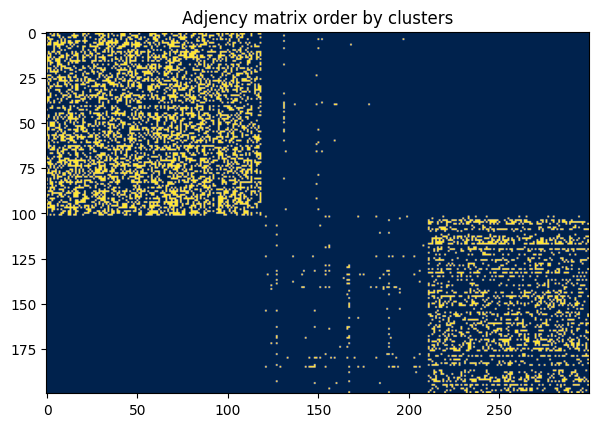

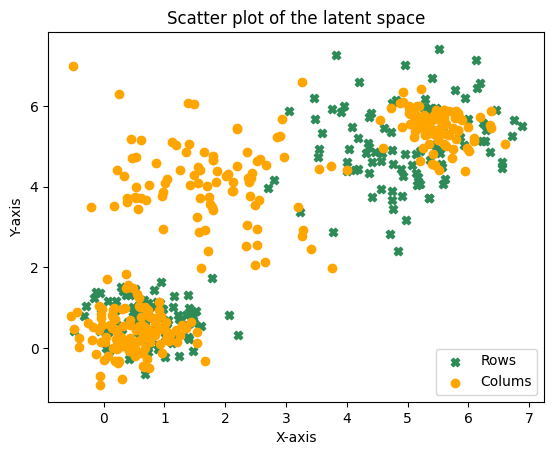

In [14]:
## Plotting the result ##
plot_block_matrix(A, r, c)
plot_latent(R,C)

## Model

In [19]:
## MODEL ELEMENTS ##

def glorot_init(input_dim, output_dim):
    """
    Glorot (or Xavier) initialization for weight parameters.
    arguments:
        input_dim : Dimension of the input (Integer)
        output_dim : Dimension of the output (Integer)
    return:
        nn.Parameter : Initialized weight parameter (nn.Parameter object)
    """
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = torch.rand(input_dim, output_dim, dtype = torch.float32) * 2 * init_range - init_range
    #initial = initial.to(device)
    return nn.Parameter(initial)

class GraphConvSparse(nn.Module):
    """
    Graph Convolutional Layer for the encoder
    """
    def __init__(self, input_dim, output_dim, adj, activation = F.relu, **kwargs):
        """
        Initialize the layer.
        arguments:
            input_dim : Dimension of the input (Integer)
            output_dim : Dimension of the output (Integer)
            adj : Adjacency matrix of the graph (Tensor of shape (N, input_dim))
            activation : Activation function to apply after convolution (Torch function, default is ReLU)
        """
        super(GraphConvSparse, self).__init__(**kwargs)
        self.weight = glorot_init(input_dim, output_dim)
        self.adj = adj
        self.activation = activation

    def forward(self, inputs):
        """
        Forward pass of the layer.
        arguments:
            inputs : Input tensor of shape (N, input_dim)
        return:
            outputs : Result tensor of shape (N, output_dim)
        """
        x = inputs
        x = torch.mm(x,self.weight)
        x = torch.mm(self.adj, x)
        outputs = self.activation(x)
        return outputs

class Encoder(nn.Module):
    """
    GCN Encoder
    This encoder contains two graph convolutional layers for encoding the input data.
    It computes the mean and log standard deviation with two separate second layers and samples from a Gaussian distribution.
    """
    def __init__(self, adj):
        """
        Initialize the encoder.
        arguments:
            adj : Normalized adjacency matrix of the graph (Tensor of shape (input_dim1, input_dim2))
        """
        super(Encoder,self).__init__()
        self.base_gcn1 = GraphConvSparse(input_dim1, hidden1_dim1, adj.T)
        self.gcn_mean1 = GraphConvSparse(hidden1_dim1, hidden2_dim1, adj, activation=lambda x:x)
        self.gcn_logstddev1 = GraphConvSparse(hidden1_dim1, hidden2_dim2, adj, activation=lambda x:torch.where(x > -3, x, -3))

        self.base_gcn2 = GraphConvSparse(input_dim2, hidden1_dim2, adj)
        self.gcn_mean2 = GraphConvSparse(hidden1_dim2, hidden2_dim1, adj.T, activation=lambda x:x)
        self.gcn_logstddev2 = GraphConvSparse(hidden1_dim2, hidden2_dim2, adj.T, activation=lambda x:torch.where(x > -3, x, -3))

    def encode1(self, A):
        """
        Encode the matrix using the rows.
        arguments:
            A : Adjacency matrix of the graph (Tensor of shape (input_dim1, input_dim2))
        return:
            sampled_X : Sampled latent representation for the rows (Tensor of shape (input_dim1, hidden2_dim1))
            mean_X : Mean of the latent representation (Tensor of shape (input_dim1, hidden2_dim1))
            logstd_X : Log standard deviation of the latent representation (Tensor of shape (input_dim1, hidden2_dim1))
        """
        Id = torch.eye(input_dim1)
        hidden1 = self.base_gcn1(Id)
        mean1 = self.gcn_mean1(hidden1)
        logstd1 = self.gcn_logstddev1(hidden1)

        gaussian_noise1 = torch.randn(A.size(0), hidden2_dim1)
        sampled_X = gaussian_noise1*torch.exp(logstd1) + mean1

        return sampled_X, mean1, logstd1

    def encode2(self, A):
        """
        Encode the matrix using the columns.
        arguments:
            A : Adjacency matrix of the graph (Tensor of shape (input_dim1, input_dim2))
        return:
            sampled_Y : Sampled latent representation for the columns (Tensor of shape (input_dim2, hidden2_dim2))
            mean_Y : Mean of the latent representation (Tensor of shape (input_dim2, hidden2_dim2))
            logstd_Y : Log standard deviation of the latent representation (Tensor of shape (input_dim2, hidden2_dim2))
        """
        Id = torch.eye(input_dim2)
        hidden2 = self.base_gcn2(Id)
        mean2 = self.gcn_mean2(hidden2)
        logstd2 = self.gcn_logstddev2(hidden2)

        gaussian_noise2 = torch.randn(A.size(1), hidden2_dim1)
        sampled_Y = gaussian_noise2*torch.exp(logstd2) + mean2

        return sampled_Y, mean2, logstd2

    def forward(self,A):
        """
        Forward pass of the encoder.
        arguments:
            A : Adjacency matrix of the graph (Tensor of shape (input_dim1, input_dim2))
        return:
            X : Sampled latent representation for the rows (Tensor of shape (input_dim1, hidden2_dim1))
            Y : Sampled latent representation for the columns (Tensor of shape (input_dim2, hidden2_dim2))
            mean_X : Mean of the latent representation for the rows (Tensor of shape (input_dim1, hidden2_dim1))
            logstd_X : Log standard deviation of the latent representation for the rows (Tensor of shape (input_dim1, hidden2_dim1))
            mean_Y : Mean of the latent representation for the columns (Tensor of shape (input_dim2, hidden2_dim2))
            logstd_Y : Log standard deviation of the latent representation for the columns (Tensor of shape (input_dim2, hidden2_dim2))
        """
        X, mean_X, logstd_X = self.encode1(A)
        Y, mean_Y, logstd_Y = self.encode2(A)

        return X, Y, mean_X, logstd_X, mean_Y, logstd_Y


class Decoder(nn.Module):
    """
    Decoder for the model.
    This decoder computes the probability of edges between the latent representations of rows and columns using the distance (LPM).
    It uses a parameter alpha to control the threshold for edge formation.
    """
    def __init__(self, alpha):
        """
        Initialize the decoder.
        arguments:
            alpha : Parameter to control the threshold for edge formation (Float)
        """
        super(Decoder, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype = torch.float32), requires_grad=True)

    def forward(self, X, Y):
        """
        Forward pass of the decoder.
        arguments:
            X : Sampled latent representation for the rows (Tensor of shape (N1, N2))
            Y : Sampled latent representation for the columns (Tensor of shape (N3, N2))
        return:
            probs : Probability of edges between the rows and columns (Tensor of shape (N1, N3))
        """
        # Calcul of the euclidean distance squared between each pair
        X_exp = X.unsqueeze(1)
        Y_exp = Y.unsqueeze(0)
        diff = X_exp - Y_exp
        norm_sq = torch.sum(diff**2, dim=2)

        # Calculation of the probability (sigmoid(alpha - ||X-Y||^2) )
        term = self.alpha - 0.5*norm_sq
        probs = torch.sigmoid(term)
    
        return probs

In [58]:
## VAE Model ##

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) model for graph data.
    It uses graph convolutional network for encoding and a distance-based decoder for reconstructing the adjacency matrix.
    """
    def __init__(self, adj_norm, alpha):
        """
        Initialize the VAE model.
        arguments:
            adj_norm : Normalized adjacency matrix of the graph (Tensor of size (M, P))
            alpha : Parameter to control the threshold for edge formation in the decoder (Float)
        """
        super(VAE, self).__init__()
        self.adj_norm = adj_norm
        self.encoder = Encoder(adj_norm)
        self.decoder = Decoder(alpha)

        # Initialization of the parameters of the clusters

        self.gamma = nn.Parameter(torch.FloatTensor(M,L).fill_(1.0/L), requires_grad=False)
        self.delta = nn.Parameter(torch.FloatTensor(P,Q).fill_(1.0/Q), requires_grad=False)

        self.pi = nn.Parameter(torch.FloatTensor(L).fill_(1.0/L), requires_grad=False)
        self.tau = nn.Parameter(torch.FloatTensor(Q).fill_(1.0/Q), requires_grad=False)
        
        self.mu = nn.Parameter(torch.FloatTensor(np.random.multivariate_normal(np.zeros(D),np.eye(D),L)), requires_grad=False)
        self.m = nn.Parameter(torch.FloatTensor(np.random.multivariate_normal(np.zeros(D),np.eye(D),Q)), requires_grad=False)

        self.log_sigma = nn.Parameter(torch.FloatTensor(L).fill_(1), requires_grad=False)
        self.log_s = nn.Parameter(torch.FloatTensor(Q).fill_(1), requires_grad=False)


    def init_param(self, columns, rows, nbr_cluster_col, nbr_cluster_row) :

        row_clusters, mu_km = kmeans(X=rows, num_clusters=nbr_cluster_row, distance='euclidean')
        col_clusters, m_km = kmeans(X=columns, num_clusters=nbr_cluster_col, distance='euclidean')

        gamma_km = F.one_hot(row_clusters)
        delta_km = F.one_hot(col_clusters)

        pi_km = torch.mean(gamma_km, dim=0, dtype= torch.float)
        tau_km = torch.mean(delta_km, dim=0, dtype= torch.float)

        sigma_km = torch.zeros(nbr_cluster_row)
        for c in range(nbr_cluster_row) :
            sigma_km[c] = torch.std(rows[row_clusters==c])

        s_km = torch.zeros(nbr_cluster_col)
        for c in range(nbr_cluster_col) :
            s_km[c] = torch.std(columns[col_clusters==c])

        log_sigma_km = torch.log(sigma_km)
        log_s_km = torch.log(s_km)

        return gamma_km, delta_km, pi_km, tau_km, mu_km, m_km, log_sigma_km, log_s_km
    


    def pretrain(self, A, adj_label, kl_weight = 0.0001):
        """
        Pretrain the VAE model using the provided adjacency matrix and labels.
        arguments:
            A : Adjacency matrix of the graph (Tensor of size (M, P))
            adj_label : Original adjacency matrix (used for computing loss) (Tensor of size (M, P))
            kl_weight : Weight for the KL divergence term in the loss (Float) (default is 0.0001)
        return:
            X : Sampled latent representation for the rows (Tensor of size (M, D))
            Y : Sampled latent representation for the columns (Tensor of size (P, D))
            A_probs : Probability of edges between the rows and columns (Tensor of size (M, P))
            store_pre_loss : Tensor to store the loss values for each epoch (Tensor of size (pre_epoch))
            store_recon_loss : Tensor to store the reconstruction loss values for each epoch (Tensor of size (pre_epoch))
            store_kl_loss : Tensor to store the KL divergence loss values for each epoch (Tensor of size (pre_epoch))
        """

        # Adam optimizer
        optimizer = Adam(itertools.chain(self.encoder.parameters(), self.decoder.parameters()), lr=learning_rate)

        store_pre_loss = torch.zeros(pre_epoch)
        store_kl_loss = torch.zeros(pre_epoch)
        store_recon_loss = torch.zeros(pre_epoch)

        # Weights for the positive and negative samples in the binary cross-entropy loss
        pos_weight = float(adj_label.numel() - adj_label.sum()) / adj_label.sum()

        # Pretraining loop
        for epoch in range(pre_epoch):

            # Encoder forward pass
            X, Y, mean_X, logstd_X, mean_Y, logstd_Y = self.encoder(A)

            # Decoder forward pass
            A_probs = self.decoder(X, Y)

            # Reconstruction loss
            recon_loss = F.binary_cross_entropy(A_probs.view(-1),adj_label.view(-1), weight=pos_weight)

            # KL divergence loss
            kl_divergence_X = 0.5 * torch.mean( 2 * (- 1 - 2 * logstd_X + torch.exp(2 * logstd_X)) + mean_X.pow(2))
            kl_divergence_Y = 0.5 * torch.mean( 2 * (- 1 - 2 * logstd_Y + torch.exp(2 * logstd_Y)) + mean_Y.pow(2))

            # Total loss
            loss = recon_loss - kl_weight * (kl_divergence_X + kl_divergence_Y)

            # Model parameters update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            store_pre_loss[epoch] = loss.item()
            store_kl_loss[epoch] = kl_weight * (kl_divergence_X + kl_divergence_Y)
            store_recon_loss[epoch] = recon_loss
            
        # Initialize the parameters of the clusters
        self.gamma.data, self.delta.data, self.pi.data, self.tau.data, self.mu.data, self.m.data, self.log_sigma.data, self.log_s.data = self.init_param(Y, X, Q, L)

        print('Pretraining terminé !')
        return X, Y, A_probs, store_pre_loss, store_recon_loss, store_kl_loss
    


    def kullback_leibler_divergence(self, mean, mean_gcn, logstd, logstd_gcn):
        """
        Compute the Kullback-Leibler divergence between two Gaussian distributions.
        arguments :
            mean : Mean of the clusters (Tensor of shape (N2, D))
            mean_gcn : Mean of the GCN (Tensor of shape (N1, D))
            logstd : Log standard deviation of the clusters (Tensor of shape (N2, 1))
            logstd_gcn : Log standard deviation of the GCN (Tensor of shape (N1, 1))
        return :
            Kullback-Leibler divergence (Tensor of shape (N1, N2, D))
        """
        
        latent_dim = mean_gcn.shape[1]

        var_gcn = torch.exp(2*logstd_gcn)
        var = torch.exp(2*logstd) + 1e-16
        
        mean_gcn = mean_gcn.unsqueeze(1)
        mean = mean.unsqueeze(0)

        logvar_gcn = 2*logstd_gcn
        logvar = 2*logstd

        D_KL = 0.5 * (latent_dim * (logvar - logvar_gcn - 1 + var_gcn/var) + torch.sum((mean_gcn - mean)**2, dim=2) / var)

        return D_KL



    def update_var_probability(self, prior, mean, mean_gcn, log_std, logstd_gcn):
        """
        Update the variationnal probability of individuals in the clusters.
        arguments :
            prior : Prior distribution
            mean : Mean of the clusters
            mean_gcn : Mean of the GCN
            std : Log of standard deviation of the clusters
            std_gcn : Log of standard deviation of the GCN
        return :
            Updated variational probability for each individual in each cluster (Tensor of shape (N2, N1, D))
        """
        point_dim = mean_gcn.shape[0]
        cluster_dim = prior.shape[0]
        latent_dim = mean_gcn.shape[1]
        
        var_prob = torch.zeros((point_dim, cluster_dim, latent_dim), dtype=torch.float32)
        dkl = self.kullback_leibler_divergence(mean, mean_gcn, log_std, logstd_gcn)

        log_numerator = torch.log(prior) - dkl
        max_log_numerator = torch.max(log_numerator, dim=1, keepdim=True).values
        log_denominator = max_log_numerator + (torch.logsumexp(torch.log(prior) - dkl - max_log_numerator, dim=1, keepdim=True))
        var_prob = torch.exp(log_numerator - log_denominator)
    
        return var_prob
    

    
    def update_others_parameters(self, prob_var, mean, mean_gcn, logstd_gcn):
        """
        Update the parameters of the clusters.
        arguments :
            prob_var : Variational probability for each individual in each cluster (Tensor of shape (N1, N2))
            mean : Mean of the clusters (Tensor of shape (N2, D))
            mean_gcn : Mean of the GCN (Tensor of shape (N2, D))
            logstd_gcn : Log standard deviation of the GCN (Tensor of shape (N2, 1))
        return :
            prior : Updated prior distribution (Tensor of shape (N2,))
            new_mean : Updated means of the clusters (Tensor of shape (N2, D))
            new_logstd : Updated log of standard deviations of the clusters (Tensor of shape (N2, 1))
        """

        latent_dim = mean_gcn.shape[1]
    
        prob_var_sum = torch.sum(prob_var, dim=0) + 1e-16
        prior = prob_var_sum / (prob_var.shape[0] + 1e-16)

        mean_gcn = mean_gcn.unsqueeze(1)
        mean = mean.unsqueeze(0)

        # Update the mean
        new_mean = torch.sum(prob_var.unsqueeze(2) * mean_gcn, dim=0) / prob_var_sum.unsqueeze(1)
    
        # Update the standard deviation
        numerator_mean = torch.sum(prob_var * (torch.sum((mean_gcn - mean)**2, dim=2)), dim=0)
        mean_part = numerator_mean / (latent_dim * prob_var_sum + 1e-16)
        # Calculation with logsumexp for numerical stability
        max_numerator_std = torch.max(torch.log(prob_var) + 2*logstd_gcn, dim=0, keepdim=True).values
        numerator_std = max_numerator_std + torch.logsumexp(torch.log(prob_var) + 2*logstd_gcn - max_numerator_std, dim=0)
        denominator_std = torch.logsumexp(torch.log(prob_var), dim=0)
        ratio_std = numerator_std - denominator_std
        std_part = torch.exp(ratio_std)
        
        new_logstd = 0.5 * torch.log((mean_part + std_part))

        return prior, new_mean, new_logstd
    

    
    def train(self, A, A_label, row_cluster, column_cluster):
        """
        Train the VAE model
        arguments:
            A : Adjacency matrix of the graph (Tensor of size (M, P))
            adj_label : Original adjacency matrix (used for computing loss) (Tensor of size (M, P))
            row_cluster : True cluster labels for the rows (Numpy array of size (M,))
            column_cluster : True cluster labels for the columns (Numpy array of size (P,))
        return:
            X : Sampled latent representation for the rows (Tensor of size (M, D))
            Y : Sampled latent representation for the columns (Tensor of size (P, D))
            A_probs : Probability of edges between the rows and columns (Tensor of size (M, P))
            store_loss : Tensor to store the loss values for each epoch (Tensor of size (num_epoch))
            store_loss1 : Tensor to store the reconstruction loss values for each epoch (Tensor of size (num_epoch))
            store_loss2 : Tensor to store the KL divergence loss values for rows for each epoch (Tensor of size (num_epoch))
            store_loss3 : Tensor to store the KL divergence loss values for columns for each epoch (Tensor of size (num_epoch))
            store_loss4 : Tensor to store the cluster loss values for rows for each epoch (Tensor of size (num_epoch))
            store_loss5 : Tensor to store the cluster loss values for columns for each epoch (Tensor of size (num_epoch))
            store_ari_gamma : List to store the ARI score for rows for each epoch (List of length (num_epoch))
            store_ari_delta : List to store the ARI score for columns for each epoch (List of length (num_epoch)) 
        """

        # Adam optimizer
        optimizer = Adam(itertools.chain(self.encoder.parameters(), self.decoder.parameters()), lr=learning_rate)

        # Store the loss and Ari score
        store_loss = torch.zeros(num_epoch)
        store_loss1 = torch.zeros(num_epoch)
        store_loss2 = torch.zeros(num_epoch)
        store_loss3 = torch.zeros(num_epoch)
        store_loss4 = torch.zeros(num_epoch)
        store_loss5 = torch.zeros(num_epoch)
        store_ari_gamma = []
        store_ari_delta = []

        # Training loop
        for i in range(num_epoch):
        
            # Encoder forward pass
            X, Y, mean_X, logstd_X, mean_Y, logstd_Y = self.encoder(A)

            # Decoder forward pass
            A_probs = self.decoder(X, Y)

            # Update gamma and delta
            self.gamma.data = self.update_var_probability(self.pi, self.mu, mean_X, self.log_sigma, logstd_X)
            self.delta.data = self.update_var_probability(self.tau, self.m, mean_Y, self.log_s, logstd_Y)

            if torch.isnan(self.gamma).any() or torch.isnan(self.delta).any():
                print("NaN detected in gamma or delta")
                break

            # Update pi, tau, mu, m, sigma and s
            self.pi.data, self.mu.data, self.log_sigma.data = self.update_others_parameters(self.gamma, self.mu, mean_X, logstd_X)
            self.tau.data, self.m.data, self.log_s.data = self.update_others_parameters(self.delta, self.m, mean_Y, logstd_Y)

            # Loss of reconstruction
            recon_loss = -torch.sum(A_label * (torch.log(A_probs + 1e-16)) + (1 - A_label) * (torch.log(1 - A_probs + 1e-16)))

            # KL divergence loss
            kl_divergence_X = torch.sum(self.gamma * self.kullback_leibler_divergence(self.mu, mean_X, self.log_sigma, logstd_X))
            kl_divergence_Y = torch.sum(self.delta * self.kullback_leibler_divergence(self.m, mean_Y, self.log_s, logstd_Y))

            # Cluster loss
            loss4 = torch.sum(self.gamma * (torch.log(self.pi + 1e-16) - torch.log(self.gamma + 1e-16)))
            loss5 = torch.sum(self.delta * (torch.log(self.tau + 1e-16) - torch.log(self.delta + 1e-16)))

            # Total loss
            loss = recon_loss -  kl_divergence_X - kl_divergence_Y + (loss4 + loss5)

            # Model parameters update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the loss value
            store_loss[i] = torch.Tensor.item(loss)  # save train loss for visu
            store_loss1[i] = torch.Tensor.item(recon_loss)
            store_loss2[i] = torch.Tensor.item(torch.mean(kl_divergence_X))
            store_loss3[i] = torch.Tensor.item(torch.mean(kl_divergence_Y))
            store_loss4[i] = torch.Tensor.item(loss4)
            store_loss5[i] = torch.Tensor.item(loss5)
            
            # Store the ARI score
            store_ari_gamma.append(adjusted_rand_score(row_cluster, torch.argmax(self.gamma, axis=1).cpu().numpy()))
            store_ari_delta.append(adjusted_rand_score(column_cluster, torch.argmax(self.delta, axis=1).cpu().numpy()))
            
            if (i+1) % 100 == 0 :
                print(f"Epoch: {i + 1:04d} / {num_epoch:.0f}  |  Loss: {loss.item():.5f}  |  Recon loss: {recon_loss.item():.5f} |  ARI delta: {store_ari_delta[-1]:.5f} | ARI gamma: {store_ari_gamma[-1]:.5f}")
                
        return X, Y, A_probs, store_loss, store_loss1,store_loss2,store_loss3,store_loss4,store_loss5, store_ari_gamma, store_ari_delta

In [17]:
def normalized_adj(adj):
  """
  Normalize the adjacency matrix.
  arguments:
      adj : Adjacency matrix of the graph (Tensor of shape (M, P))
  return:
      adj_normalized : Normalized adjacency matrix (Tensor of shape (M, P))
  """
  
  # Create an diagonal matrix with the sum of the rows of adj
  rowsum = torch.sum(adj, dim=1)

  # Create a diagonal matrix with the inverse of the sum of the rows of adj
  row_degree_mat_inv_sqrt = torch.diag(1 / torch.sqrt(rowsum))

  # Create an diagonal matrix with the sum of the columns of adj
  colsum = torch.sum(adj, dim=0)

  # Create a diagonal matrix with the inverse of the sum of the columns of adj
  col_degree_mat_inv_sqrt = torch.diag(1 / torch.sqrt(colsum))

  #Replace infinite value by a non-zero value
  row_degree_mat_inv_sqrt[torch.isinf(row_degree_mat_inv_sqrt)] = 1e-6
  col_degree_mat_inv_sqrt[torch.isinf(col_degree_mat_inv_sqrt)] = 1e-6

  # Create the normalized adjacency matrix
  adj_normalized = torch.mm(torch.mm(row_degree_mat_inv_sqrt, adj), col_degree_mat_inv_sqrt)

  return adj_normalized

## Entrainement du modèle

In [59]:
# Normalize the adjacency matrix
adj_normalized = normalized_adj(A)

# Create the model
model = VAE(adj_normalized, alpha)

In [ ]:
## ONLY FOR GPU USAGE ##

# Move data to the GPU
A = A.to(device)
adj_normalized = adj_normalized.to(device)
model= model.to(device)

In [63]:
# Pretraining
X, Y, A_pred, loss, rec_l, kl_l = model.pretrain(adj_normalized, A, 0.0001)

# Training
X, Y, A_probs, store_loss, store_loss1,store_loss2,store_loss3,store_loss4,store_loss5, store_ari_gamma, store_ari_delta = model.train(adj_normalized, A, r, c)

print(f"\n !! ARI gamma = {store_ari_gamma[-1]:.5f} | ARI delta = {store_ari_delta[-1]:.5f} !! \n")

running k-means on cpu..


[running kmeans]: 4it [00:00, 170.27it/s, center_shift=0.000000, iteration=4, tol=0.000100]


running k-means on cpu..


[running kmeans]: 7it [00:00, 262.17it/s, center_shift=0.000000, iteration=7, tol=0.000100]

Pretraining terminé !


Epoch: 0100 / 3000  |  Loss: 8396.28516  |  Recon loss: 11737.48828 |  ARI delta: 0.90510 | ARI gamma: 1.00000
Epoch: 0200 / 3000  |  Loss: 8388.01562  |  Recon loss: 11751.89258 |  ARI delta: 0.91222 | ARI gamma: 1.00000
Epoch: 0300 / 3000  |  Loss: 8361.32617  |  Recon loss: 11731.58105 |  ARI delta: 0.91376 | ARI gamma: 1.00000
Epoch: 0400 / 3000  |  Loss: 8355.11133  |  Recon loss: 11728.97949 |  ARI delta: 0.91376 | ARI gamma: 1.00000
Epoch: 0500 / 3000  |  Loss: 8354.99902  |  Recon loss: 11731.96387 |  ARI delta: 0.91376 | ARI gamma: 1.00000
Epoch: 0600 / 3000  |  Loss: 8319.91211  |  Recon loss: 11700.61523 |  ARI delta: 0.92252 | ARI gamma: 1.00000
Epoch: 0700 / 3000  |  Loss: 8317.25684  |  Recon loss: 11701.41797 |  ARI delta: 0.91376 | ARI gamma: 1.00000
Epoch: 0800 / 3000  |  Loss: 8283.59180  |  Recon loss: 11669.43652 |  ARI delta: 0.91376 | ARI gamma: 1.00000
Epoch: 0900 / 3000  |  Loss: 8256.33105  |  Recon loss: 11645.02344 |  ARI delta: 0.92252 | ARI gamma: 1.00000
E

## Visualization

In [61]:
## PLOTTING FUNCTIONS ##

def plot_training_loss(loss, loss1, loss2, loss3, loss4, loss5):
    """
    Plot the training loss and its components.
    arguments :
        loss : Tensor containing the total loss values for each epoch (Tensor of shape (epoch,))
        loss1 : Tensor containing the reconstruction loss values for each epoch (Tensor of shape (epoch,))
        loss2 : Tensor containing the KL divergence loss values for rows for each epoch (Tensor of  shape (epoch,))
        loss3 : Tensor containing the KL divergence loss values for columns for each epoch (Tensor of shape (epoch,))
        loss4 : Tensor containing the cluster loss values for rows for each epoch (Tensor of shape (epoch,))
        loss5 : Tensor containing the cluster loss values for columns for each epoch (Tensor of shape (epoch,))
    """
    f, ax = plt.subplots(1, figsize=(15, 10))
    ax.remove()
    plt.subplot(251)
    plt.plot(loss1.cpu().data.numpy(), color='royalblue')
    plt.title("Reconstruction loss1")
    
    plt.subplot(252)
    plt.plot(loss2.cpu().data.numpy(), color='royalblue')
    plt.title("KL loss2")
    
    plt.subplot(253)
    plt.plot(loss3.cpu().data.numpy(), color='royalblue')
    plt.title("KL loss3")
    
    plt.subplot(254)
    plt.plot(loss4.cpu().data.numpy(), color='royalblue')
    plt.title("Cluster loss4")
    
    plt.subplot(255)
    plt.plot(loss5.cpu().data.numpy(), color='royalblue')
    plt.title("Cluster loss5")
    
    plt.subplot(212)
    plt.plot(loss.cpu().data.numpy(), color='royalblue')
    plt.title("Training loss in total")
    
    plt.show()

def plot_ARI(ari_row, ari_col):
    """
    Plot the ARI score for rows and columns during training.
    arguments :
        ari_row : List containing the ARI score for rows for each epoch (List of length (epoch))
        ari_col : List containing the ARI score for columns for each epoch (List of length (epoch))
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(121)
    plt.plot(ari_row, color='royalblue')
    plt.title("ARI for gamma")
    plt.subplot(122)
    plt.plot(ari_col, color='royalblue')
    plt.title("ARI for delta")
    plt.show()

def plot_latent_clusters(X, Y, r, c):
    """
    Plot the latent space of the rows and columns with clusters.
    arguments :
        X : rows latent positions (Tensor of shape (M, D))
        Y : columns latent positions (Tensor of shape (P, D))
        r : Cluster membership for the rows (Numpy array of shape (M,))
        c : Cluster membership for the columns (Numpy array of shape (P,))
    """

    # Custom colormap
    oranges = ['sienna', 'purple', 'goldenrod', 'deeppink', 'r']
    cmap_orange = LinearSegmentedColormap.from_list("custom_cmap", oranges)
    greens = ['yellowgreen', 'mediumseagreen', 'darkgreen']
    cmap_green = LinearSegmentedColormap.from_list("custom_cmap", greens)

    # Plot the latent space with clusters
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c=r, cmap=cmap_green, marker='o', label='Rows')
    plt.scatter(Y[:, 0].detach().numpy(), Y[:, 1].detach().numpy(), c=c, cmap=cmap_orange, marker='^', label='Columns')
    plt.title("Latent representation with estimated clusters")
    plt.legend()
    plt.show()

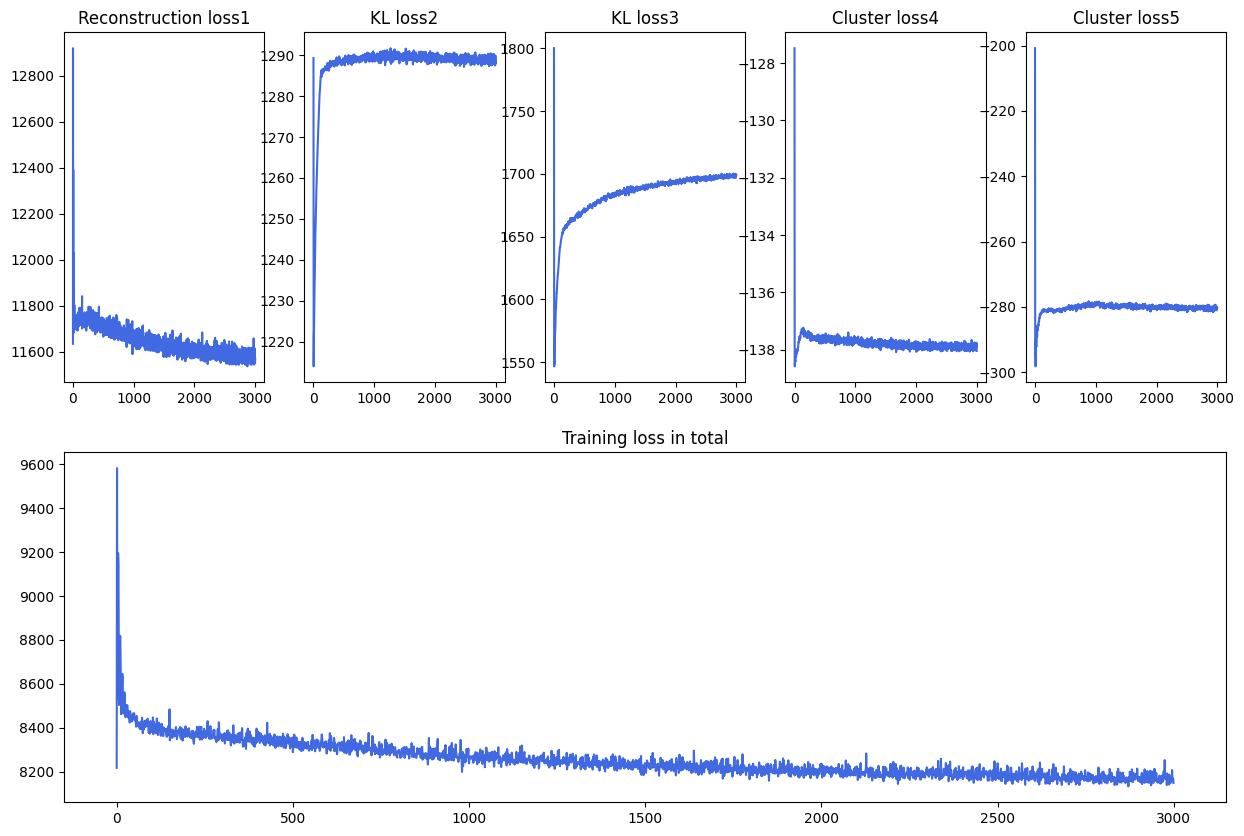

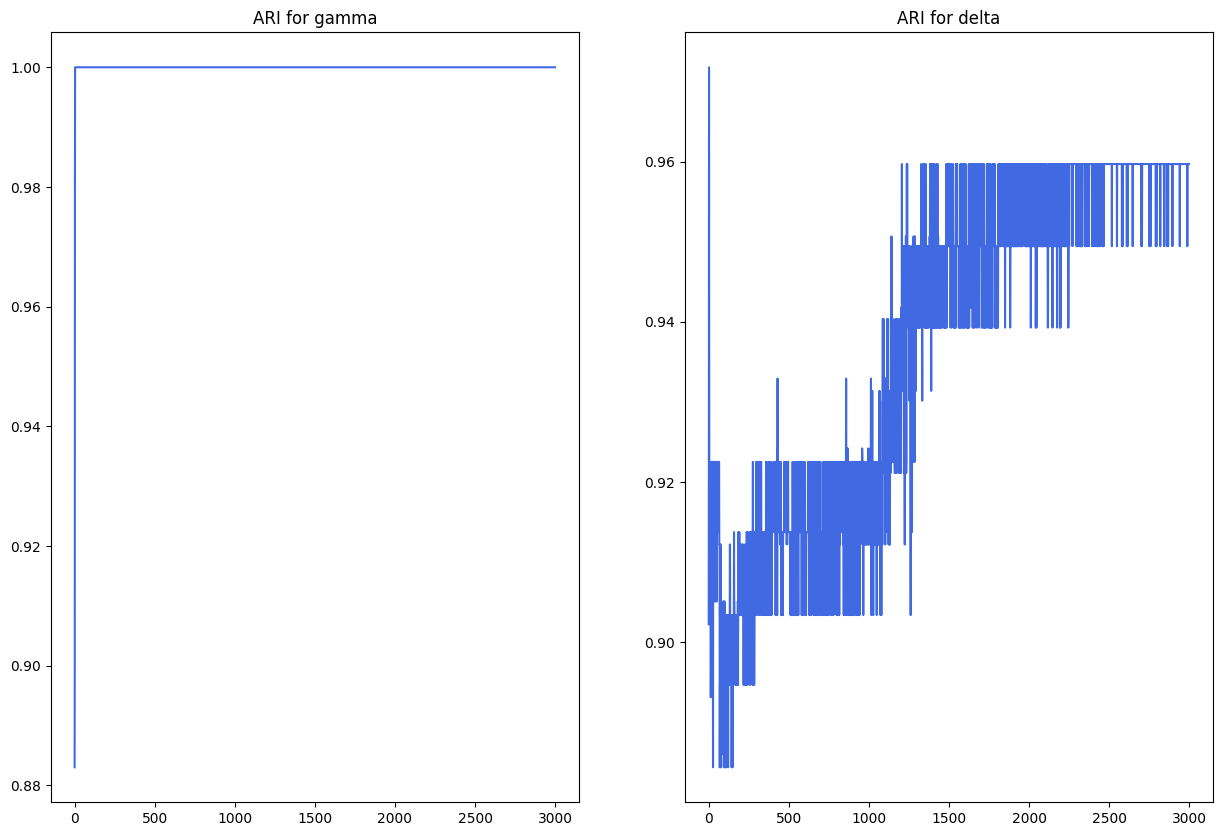

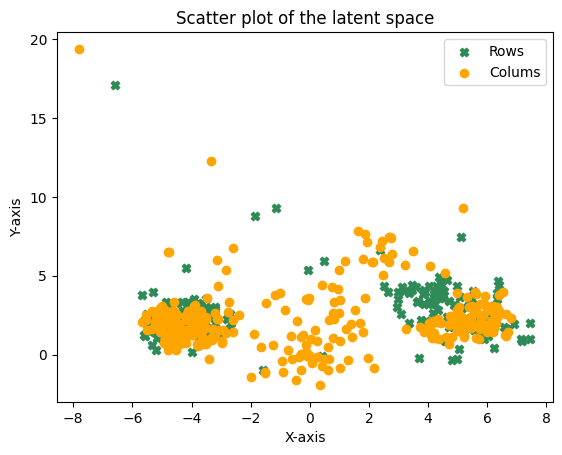

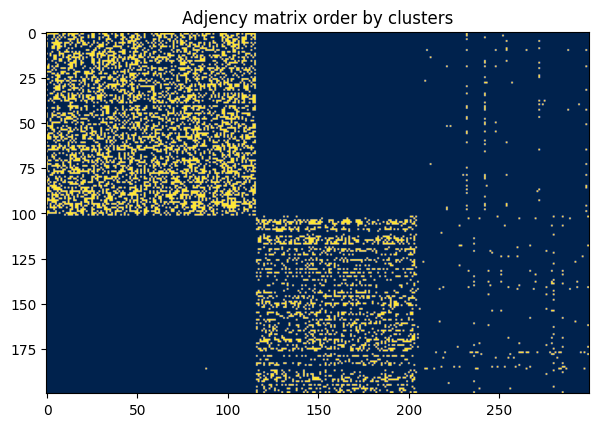

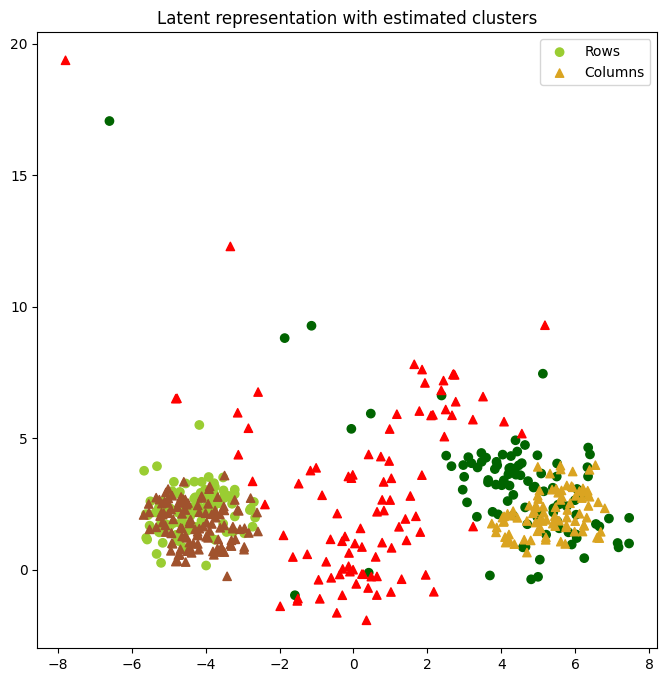

In [64]:
plot_training_loss(store_loss, store_loss1, store_loss2, store_loss3, store_loss4, store_loss5)
plot_ARI(store_ari_gamma, store_ari_delta)
plot_latent(X.detach().numpy(), Y.detach().numpy())

# Reconstructed adjacency matrix with the estimated clusters
A_fin = torch.bernoulli(A_probs)
c_est = torch.argmax(model.delta, axis=1).cpu().numpy()
r_est = torch.argmax(model.gamma, axis=1).cpu().numpy()
plot_block_matrix(A_fin.detach().numpy(), r_est, c_est)

plot_latent_clusters(X, Y, r_est, c_est)

## Test against LBM

In [47]:
# Test LBM model on our data

model_row_labels = torch.argmax(model.gamma, axis=1).cpu().numpy()
model_column_labels = torch.argmax(model.delta, axis=1).cpu().numpy()

# Fit LBM model
lbm = LBM(L,Q,n_init_total_run=1, verbosity=False)
lbm.fit(A)

# Calculate CARI
lbm_cari = CARI(r,c,lbm.row_labels,lbm.column_labels)
model_cari = CARI(r,c,model_row_labels,model_column_labels)

# Print the results
print("Our Model result :")
print("Adjusted Rand index for rows is {:.2f}".format(store_ari_gamma[-1]))
print("Adjusted Rand index for columns is {:.2f}".format(store_ari_delta[-1]))
print("Co-Adjusted Rand index is {:.2f}".format(model_cari))

print("\nLBM result :")
print("Adjusted Rand index for rows is {:.2f}".format(adjusted_rand_score(r, lbm.row_labels)))
print("Adjusted Rand index for columns is {:.2f}".format(adjusted_rand_score(c, lbm.column_labels)))
print("Co-Adjusted Rand index from lbm is {:.2f}".format(lbm_cari))

Our Model result :
Adjusted Rand index for rows is 1.00
Adjusted Rand index for columns is 0.94
Co-Adjusted Rand index is 0.95

LBM result :
Adjusted Rand index for rows is 0.98
Adjusted Rand index for columns is 0.93
Co-Adjusted Rand index from lbm is 0.93


Adjacency matrix with the estimated clusters from our model :


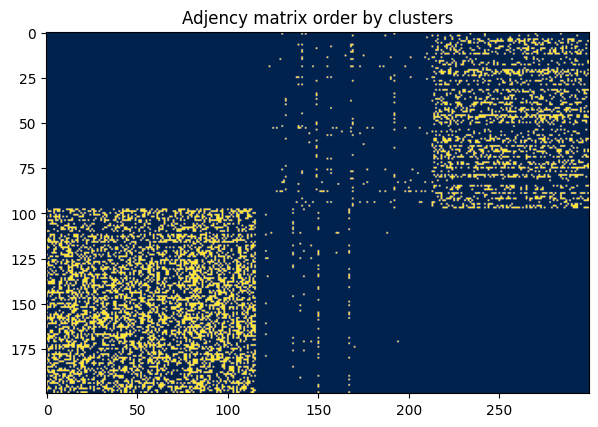

Adjacency matrix with the estimated clusters from LBM :


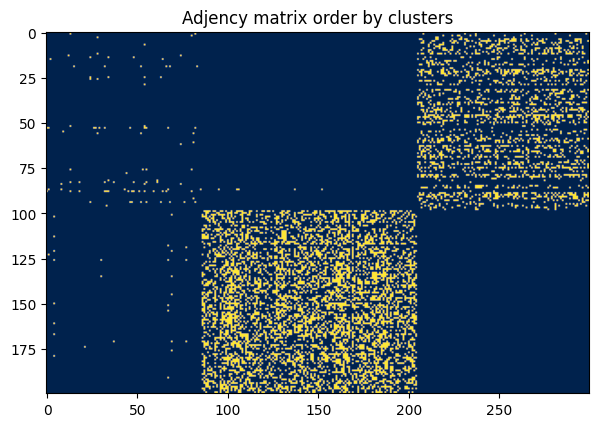

In [51]:
# Plot the adjacency matrix with the estimated clusters from our model and from LBM

print("Adjacency matrix with the estimated clusters from our model :")
plot_block_matrix(A.detach().numpy(), r_est, c_est)
print("Adjacency matrix with the estimated clusters from LBM :")
plot_block_matrix(A.detach().numpy(), lbm.row_labels, lbm.column_labels)